In [3]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.metrics import accuracy_score
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, Dropout,Bidirectional
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

##DATASET PREPPARE

In [4]:
def add_gaussian_noise(data):
    mu=0
    sigma=np.std(data)*0.5
    noise = np.random.normal(mu, sigma, data.shape)
    data1=data+noise
    sigma=np.std(data)*0.6
    noise = np.random.normal(mu, sigma, data.shape)
    data2=data+noise
    sigma=np.std(data)*0.8
    noise = np.random.normal(mu, sigma, data.shape)
    data5=data+noise
    sigma=np.std(data)*0.7
    noise = np.random.normal(mu, sigma, data.shape)
    data3=data+noise
    sigma=np.std(data)*1
    noise = np.random.normal(mu, sigma, data.shape)
    data4=data+noise
    
    return pd.concat([data,data1,data2,data3,data4,data5]).sample(frac=1)

In [ ]:
# data genrate k liye funcs
def gen_data_w(i):
    csv_files = [f'dataset/{j}.csv' for j in range(15*(i-1)+1, 15*i+1)]
    df=pd.concat([pd.read_csv(f) for f in csv_files])
    #make a new column Anamoly and assign 0 to it if it is normal and 1 if it is abnormal
    df['Anomaly'] = np.where( df["Anomaly_Type"] == 0, 0, 1)
    return df
def gen_data_custom(list):
    #the list will have the patients for whom data i want to merge
    csv_files=[]
    for j in list:
        for i in range(15*(j-1)+1, 15*j+1):
            csv_files.append(f'dataset/{i}.csv')
    df=pd.concat([pd.read_csv(f) for f in csv_files])
    df_new=df[df["Anomaly_Type"] == 0]
    # df_new2=add_gaussian_noise(df_new)
    # df_new3=add_gaussian_noise(df_new)
    # df_new=pd.concat([df_new,df_new2,df_new3])
    
    return df_new.sample(frac=1)
def data_allp_tr():
    csv_files = [f'dataset/{j}.csv' for j in range(1, 241)]
    df=pd.concat([pd.read_csv(f) for f in csv_files])
    df_new=df[ df["Anomaly_Type"] == 0]
    return df_new['Body_Temperature'], df_new['Heart_Rate'], df_new['Pulse_Rate'], df_new['SpO2'], df_new['ECG']
def gen_data_normal(i):
    # i is patient number
    # so data for i patient is from cvs files 15*i+1 to 15*i+15
    csv_files = [f'dataset/{j}.csv' for j in range(15*(i-1)+1, 15*i+1)]
    df=pd.concat([pd.read_csv(f) for f in csv_files])
    # print(df['Normal'].value_counts())
    # df=pd.read_csv(r'dataset/'+str(i)+'.csv')
    df_new=df[ df["Anomaly_Type"] == 0]
    return df_new['Body_Temperature'], df_new['Heart_Rate'], df_new['Pulse_Rate'], df_new['SpO2'], df_new['ECG']
def gen_data_abnormal(i):
    csv_files = [f'dataset/{j}.csv' for j in range(15*(i-1)+1, 15*i+1)]
    df=pd.concat([pd.read_csv(f) for f in csv_files])
    df_new=df[df["Anomaly_Type"] != 0]
    return df_new['Body_Temperature'], df_new['Heart_Rate'], df_new['Pulse_Rate'], df_new['SpO2'], df_new['ECG']

#dataset ko sequence me convert k liye
def create_dataset(X, time_steps=1):
    Xs= []
    for i in range(len(X)-time_steps+1):
        v=X[i:(i+time_steps)]
        Xs.append(v)
    return np.array(Xs)


Data Analysis

In [ ]:
df=pd.DataFrame()
for i in range(1,17):
    data=gen_data_normal(i)
    df=pd.concat([df,data])

import seaborn as sns
for i in df.columns:
    if i=='Anomaly_Type':
        continue
    if i=='Anomaly':
        continue
    if i=='Normal':
        continue
    sns.kdeplot(df[i],fill=True)
    plt.title(i)
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'dataset/1.csv'

MODELS

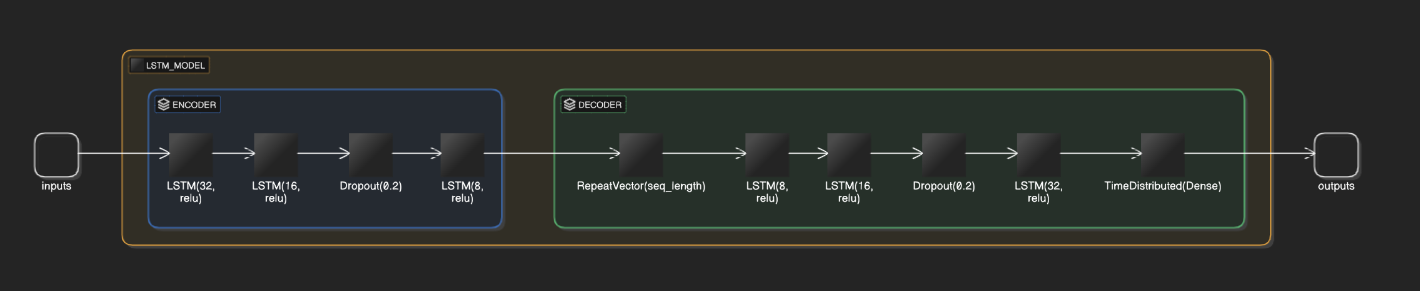

In [ ]:
from IPython.display import Image
Image(filename='model.png') 

In [ ]:
# models

# def build_autoencoder(seq_length, num_features):
#     inputs = Input(shape=(seq_length, num_features))
#     encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
#     encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
#     decoded = RepeatVector(seq_length)(encoded)
#     decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
#     decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
#     decoded = TimeDistributed(Dense(num_features))(decoded)
#     model = Model(inputs, decoded)
#     model.compile(optimizer='adam', loss='mse')
#     return model

# def LSTM_encoder_custom(seq_length, num_features):
#     inputs = Input(shape=(seq_length, num_features))
#     encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
#     encoded = LSTM(32, activation='relu', return_sequences=True)(encoded)
#     encoded = LSTM(16, activation='relu', return_sequences=True)(encoded)
#     encoded = LSTM(16, activation='relu', return_sequences=False)(encoded)
#     decoded = RepeatVector(seq_length)(encoded)
#     decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
#     decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
#     decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
#     decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
#     decoded = TimeDistributed(Dense(num_features))(decoded)
#     model = Model(inputs, decoded)
#     model.compile(optimizer='adam', loss='mse')
#     return model
def LSTM_encoder_custom(seq_length, num_features):
    inputs = Input(shape=(seq_length, num_features))

    # Encoder
    encoded = LSTM(32, activation='relu', return_sequences=True)(inputs)
    encoded = LSTM(16, activation='relu', return_sequences=True)(encoded)
    encoded=Dropout(0.2)(encoded)
    encoded = LSTM(8, activation='relu', return_sequences=False)(encoded)
    # Decoder
    decoded = RepeatVector(seq_length)(encoded)
    decoded = LSTM(8, activation='relu', return_sequences=True)(decoded)
    decoded = LSTM(16, activation='relu', return_sequences=True)(decoded)
    decoded=Dropout(0.2)(decoded)
    decoded = LSTM(32, activation='relu', return_sequences=True)(decoded)
    decoded = TimeDistributed(Dense(num_features, activation='linear', kernel_regularizer=l2(0.001)))(decoded)
    model = Model(inputs, decoded)
    model.compile(optimizer=Adam(learning_rate=0.008), loss='mse')

    return model

# def LSTM_encoder_ecg(seq_length, num_features):
#     inputs = Input(shape=(seq_length, num_features))

#     encoded = Bidirectional(LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001)))(inputs)
#     encoded = Bidirectional(LSTM(32, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.001)))(encoded)
#     decoded = RepeatVector(seq_length)(encoded)
#     decoded = Bidirectional(LSTM(32, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001)))(decoded)
#     decoded = Bidirectional(LSTM(64, activation='tanh', return_sequences=True, kernel_regularizer=l2(0.001)))(decoded)
#     decoded = TimeDistributed(Dense(num_features, activation='linear'))(decoded)

#     model = Model(inputs, decoded)
#     model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

#     return model
def simple_autoencoder():
    autoencoder = keras.Sequential([
    keras.layers.Dense(8, activation='relu', input_shape=(1,)),
    keras.layers.Dense(4, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(1, activation='linear')
    ])
    return autoencoder


##TRAINING

In [ ]:
list_t=[5,9,13,16]
EPOCH=20

Index(['Body_Temperature', 'Heart_Rate', 'Pulse_Rate', 'SpO2', 'ECG',
       'Anomaly_Type', 'Normal'],
      dtype='object')

Index(['Body_Temperature', 'Heart_Rate', 'Pulse_Rate', 'SpO2', 'ECG',
       'Anomaly_Type', 'Normal', 'Anomaly'],
      dtype='object')

In [ ]:
# to store outputs of test data for final comparison 
mse_temp=[]
mse_hr=[]
mse_pr=[]
mse_spo2=[]
mse_ecg=[]

#for markov model
mse_train_temp = []
mse_test_temp = []
mse_train_hr=[]
mse_test_hr=[]
mse_train_pr=[]
mse_test_pr=[]
mse_train_spo2=[]
mse_test_spo2=[]
mse_train_ecg=[]
mse_test_ecg=[]

Temperature

In [ ]:
seq_len=1
scaler=StandardScaler()
df = gen_data_custom(list_t)
# print(df.columns)
temp_train= add_gaussian_noise(df['Body_Temperature'])

temp_train=scaler.fit_transform(np.array(temp_train).reshape(-1,1))

X_train=create_dataset(temp_train,seq_len)
model_temp=LSTM_encoder_custom(seq_len,1)
# print(model_temp.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_temp.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
# model_temp.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,verbose=1)
X_pred_train=model_temp.predict(X_train)
mse_train=np.mean(np.power(X_train-X_pred_train,2),axis=(1,2))
mse_train_temp=np.power(X_train-X_pred_train,2).squeeze()
# setting threshold to mean +3*std
threshold_temp=np.mean(mse_train)+3*np.std(mse_train)
accuracies_temp=[]
for i in range(1,17):
    df_test = gen_data_w(i)
    temp_test=scaler.transform(np.array(df_test['Body_Temperature']).reshape(-1,1))
    X_test=create_dataset(temp_test,seq_len)
    X_pred_test=model_temp.predict(X_test)
    mse_test=np.mean(np.power(X_test-X_pred_test,2),axis=(1,2))
    mse_test_temp=np.power(X_test-X_pred_test,2).squeeze()
    mse_test=np.where(mse_test>threshold_temp,1,0)
    mse_temp.append(mse_test)
    accuracies_temp.append(accuracy_score(df_test['Anomaly'],mse_test)*100)

# print(f"Accuraies for all patients with training on {list}")
# for i in range(1,17):
#     print(f'Patient {i} : {accuracies_temp[i-1]*100:.3f}')
print(np.mean(accuracies_temp))

Epoch 1/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 30s 13ms/step - loss: 1.0068 - val_loss: 0.9915
Epoch 2/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 1.0046 - val_loss: 0.9944
Epoch 3/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.9980 - val_loss: 0.9916
Epoch 4/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - loss: 0.9996 - val_loss: 0.9930
Epoch 5/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.9974 - val_loss: 0.9973
Epoch 6/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 1.0053 - val_loss: 0.9919
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━

Heart Rate

In [ ]:
seq_len=1
scaler=StandardScaler()
df = gen_data_custom(list_t)
hr_train=add_gaussian_noise(df['Heart_Rate'])
hr_train=scaler.fit_transform(np.array(hr_train).reshape(-1,1))
X_train=create_dataset(hr_train,seq_len)
model_hr=LSTM_encoder_custom(seq_len,1)
# print(model_hr.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_hr.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
# model_hr.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,verbose=1)
X_pred_train=model_hr.predict(X_train)
mse_train=np.mean(np.power(X_train-X_pred_train,2),axis=(1,2))
mse_train_hr = np.power(X_train-X_pred_train,2).squeeze()
# setting threshold to mean +3*std
threshold_hr=np.mean(mse_train)+2*np.std(mse_train)
accuracies_hr=[]
for i in range(1,17):
    df_test = gen_data_w(i)
    hr_test=scaler.transform(np.array(df_test['Heart_Rate']).reshape(-1,1))
    X_test=create_dataset(hr_test,seq_len)
    X_pred_test=model_hr.predict(X_test)
    mse_test=np.mean(np.power(X_test-X_pred_test,2),axis=(1,2))
    mse_test_hr = np.power(X_test-X_pred_test,2).squeeze()
    mse_test=np.where(mse_test>threshold_hr,1,0)
    mse_hr.append(mse_test)
    accuracies_hr.append(accuracy_score(df_test['Anomaly'],mse_test)*100)

# print(f"Accuraies for all patients with training on {list_t}")
# for i in range(1,17):
#     print(f'Patient {i} : {accuracies_hr[i-1]:.3f}')
print(np.mean(accuracies_hr))

Epoch 1/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 28s 10ms/step - loss: 0.2225 - val_loss: 0.0604
Epoch 2/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0085 - val_loss: 0.0616
Epoch 3/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0082 - val_loss: 0.0578
Epoch 4/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0054 - val_loss: 0.0757
Epoch 5/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0040 - val_loss: 0.0673
Epoch 6/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 0.0044 - val_loss: 0.0689
Epoch 7/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0040 - val_loss: 0.0633
Epoch 8/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0033 - val_loss: 0.0753
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

Pulse Rate

In [ ]:
seq_len=1
scaler=StandardScaler()
df = gen_data_custom(list_t)
pr_train=add_gaussian_noise(df['Pulse_Rate'])
pr_train=scaler.fit_transform(np.array(pr_train).reshape(-1,1))
X_train=create_dataset(pr_train,seq_len)
model_pr=LSTM_encoder_custom(seq_len,1)
# print(model_pr.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_pr.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
# model_pr.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,verbose=1)
X_pred_train=model_pr.predict(X_train)
mse_train=np.mean(np.power(X_train-X_pred_train,2),axis=(1,2))
mse_train_pr = np.power(X_train-X_pred_train,2).squeeze()
threshold_pr=np.mean(mse_train)+3*np.std(mse_train)
accuracies_pr=[]
for i in range(1,17):
    df_test = gen_data_w(i)
    pr_test=scaler.transform(np.array(df_test['Pulse_Rate']).reshape(-1,1))
    X_test=create_dataset(pr_test,seq_len)
    X_pred_test=model_pr.predict(X_test)
    mse_test=np.mean(np.power(X_test-X_pred_test,2),axis=(1,2))
    mse_test_pr = np.power(X_test-X_pred_test,2).squeeze()
    mse_test=np.where(mse_test>threshold_pr,1,0)
    mse_pr.append(mse_test)
    accuracies_pr.append(accuracy_score(df_test['Anomaly'],mse_test)*100)

# print(f"Accuraies for all patients with training on {list}")
# for i in range(1,17):
#     print(f'Patient {i} : {accuracies_pr[i-1]*100:.3f}')
print(np.mean(accuracies_pr))

Epoch 1/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - loss: 0.2158 - val_loss: 0.0703
Epoch 2/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0091 - val_loss: 0.0487
Epoch 3/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0049 - val_loss: 0.0613
Epoch 4/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0049 - val_loss: 0.0748
Epoch 5/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 18s 11ms/step - loss: 0.0053 - val_loss: 0.0714
Epoch 6/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0042 - val_loss: 0.0512
Epoch 7/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0044 - val_loss: 0.0488
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141

Spo2

In [ ]:
seq_len=1
scaler=StandardScaler()
df = gen_data_custom(list_t)
spo2_train=add_gaussian_noise(df['SpO2'])
spo2_train=scaler.fit_transform(np.array(spo2_train).reshape(-1,1))
X_train=create_dataset(spo2_train,seq_len)          
model_spo2=LSTM_encoder_custom(seq_len,1)
# print(model_spo2.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_spo2.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
# model_spo2.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,verbose=0)
X_pred_train=model_spo2.predict(X_train)
mse_train=np.mean(np.power(X_train-X_pred_train,2),axis=(1,2))
mse_train_spo2 = np.power(X_train-X_pred_train,2).squeeze()

threshold_spo2=np.mean(mse_train)+3*np.std(mse_train)
accuracies_spo2=[]
for i in range(1,17):
    df_test = gen_data_w(i)
    spo2_test=scaler.transform(np.array(df_test['SpO2']).reshape(-1,1))
    X_test=create_dataset(spo2_test,seq_len)
    X_pred_test=model_spo2.predict(X_test)
    mse_test=np.mean(np.power(X_test-X_pred_test,2),axis=(1,2))
    mse_test_spo2 = np.power(X_test-X_pred_test,2).squeeze()
    mse_test=np.where(mse_test>threshold_spo2,1,0)
    mse_spo2.append(mse_test)
    accuracies_spo2.append(accuracy_score(df_test['Anomaly'],mse_test)*100)

# print(f"Accuraies for all patients with training on {list}")
# for i in range(1,17):
#     print(f'Patient {i} : {accuracies_spo2[i-1]*100:.3f}')
print(np.mean(accuracies_spo2))

Epoch 1/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 30s 9ms/step - loss: 0.2134 - val_loss: 0.0292
Epoch 2/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0084 - val_loss: 0.0388
Epoch 3/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0052 - val_loss: 0.0419
Epoch 4/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 0.0054 - val_loss: 0.0516
Epoch 5/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0037 - val_loss: 0.0463
Epoch 6/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0035 - val_loss: 0.0621
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
141/141 ━━━━

ECG

In [ ]:
seq_len=1
scaler=StandardScaler()
df = gen_data_custom(list_t)
ecg_train=add_gaussian_noise(df['ECG'])
ecg_train=scaler.fit_transform(np.array(ecg_train).reshape(-1,1))
X_train=create_dataset(ecg_train,seq_len)
model_ecg=LSTM_encoder_custom(seq_len,1)
# print(model_ecg.summary())
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_ecg.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,callbacks=[callback])
# model_ecg.fit(X_train,X_train,epochs=EPOCH,batch_size=32,validation_split=0.2,verbose=1)
X_pred_train=model_ecg.predict(X_train)
mse_train=np.mean(np.power(X_train-X_pred_train,2),axis=(1,2))
mse_train_ecg = np.power(X_train-X_pred_train,2).squeeze()

threshold_ecg=np.mean(mse_train)+2*np.std(mse_train)
accuracies_ecg=[]
for i in range(1,17):
    df_test = gen_data_w(i)
    ecg_test=df_test['ECG']
    ecg_test=scaler.transform(np.array(ecg_test).reshape(-1,1))
    X_test=create_dataset(ecg_test,seq_len)
    X_pred_test=model_ecg.predict(X_test)
    mse_test=np.mean(np.power(X_test-X_pred_test,2),axis=(1,2))
    mse_test_ecg = np.power(X_test-X_pred_test,2).squeeze()
    mse_test=np.where(mse_test>threshold_ecg,1,0)
    mse_ecg.append(mse_test)
    accuracies_ecg.append(accuracy_score(df_test['Anomaly'],mse_test)*100)

# print(f"Accuraies for all patients with training on {list}")
# for i in range(1,17):
#     print(f'Patient {i} : {accuracies_ecg[i-1]:.3f}')
print(np.mean(accuracies_ecg))

Epoch 1/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.2811 - val_loss: 0.0811
Epoch 2/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 15s 9ms/step - loss: 0.0117 - val_loss: 0.0730
Epoch 3/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - loss: 0.0088 - val_loss: 0.0748
Epoch 4/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - loss: 0.0083 - val_loss: 0.0585
Epoch 5/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 0.0070 - val_loss: 0.0736
Epoch 6/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - loss: 0.0051 - val_loss: 0.0653
Epoch 7/20
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - loss: 0.0064 - val_loss: 0.0616
2025/2025 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
14

##Plotting

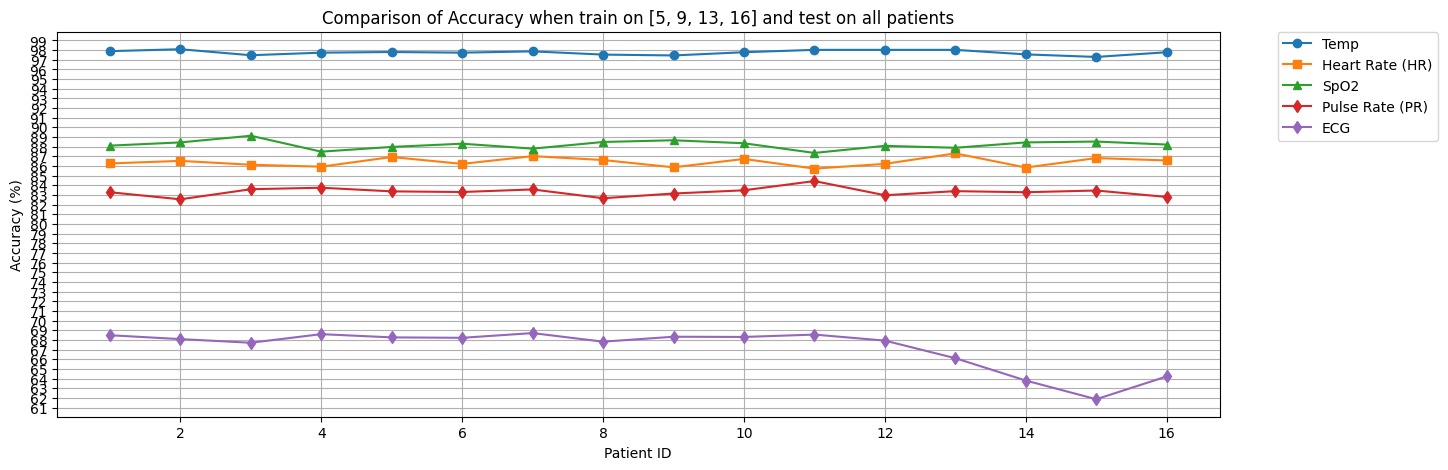

In [ ]:
patients = np.arange(1, 17)  # Patient IDs (1 to 16)

plt.figure(figsize=(15, 5))
plt.plot(patients, accuracies_temp, marker='o', linestyle='-', label="Temp")
plt.plot(patients, accuracies_hr, marker='s', linestyle='-', label="Heart Rate (HR)")
plt.plot(patients, accuracies_spo2, marker='^', linestyle='-', label="SpO2")
plt.plot(patients, accuracies_pr, marker='d', linestyle='-', label="Pulse Rate (PR)")
plt.plot(patients, accuracies_ecg, marker='d', linestyle='-', label="ECG")

# Labels and title
y_min = min(min(accuracies_temp), min(accuracies_hr), min(accuracies_spo2), min(accuracies_pr), min(accuracies_ecg))
y_max = max(max(accuracies_temp), max(accuracies_hr), max(accuracies_spo2), max(accuracies_pr), max(accuracies_ecg))
plt.yticks(np.arange(np.floor(y_min), np.ceil(y_max) + 1, 1))  # Set y-axis ticks at intervals of 1

plt.xlabel("Patient ID")
plt.ylabel("Accuracy (%)")  
plt.title(f"Comparison of Accuracy when train on {list_t} and test on all patients")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.grid(True)  
plt.show()


In [ ]:
import numpy as np

accuracies_dict = {
    'temp': accuracies_temp,
    'hr': accuracies_hr,
    'spo2': accuracies_spo2,
    'pr': accuracies_pr,
    'ecg': accuracies_ecg
}

excluded_people = [1,2,3,7,14,15]  

def filter_excluded(accuracies, excluded_indices):
    return [acc for i, acc in enumerate(accuracies) if i+1 not in excluded_indices]

def min_max_normalize(data):
    return (data) / (np.max(data) - np.min(data) + 1e-8)

def softmax(data):
    exp_data = np.exp(data)  
    return exp_data / np.sum(exp_data)

def give_score(accuracies_dict, excluded_people):
    filtered_acc = {
        key: filter_excluded(value, excluded_people) for key, value in accuracies_dict.items()
    }
    
    mean_scores = {key: np.mean(value) for key, value in filtered_acc.items()}
    print(mean_scores)
    
    data = np.array([mean_scores['temp'], mean_scores['hr'], mean_scores['spo2'], mean_scores['pr'], mean_scores['ecg']])
    data = min_max_normalize(data)
    scores = softmax(data)
    
    return scores

score = give_score(accuracies_dict, excluded_people)

temp_sc = score[0]
hr_sc = score[1]
spo2_sc = score[2]
pr_sc = score[3]
ecg_sc = score[4]

print(f"Score for temp: {temp_sc:.8f}")
print(f"Score for hr: {hr_sc:.8f}")
print(f"Score for spo2: {spo2_sc:.8f}")
print(f"Score for pr: {pr_sc:.8f}")
print(f"Score for ecg: {ecg_sc:.8f}")


{'temp': 97.78666666666666, 'hr': 86.41555555555556, 'spo2': 88.08444444444444, 'pr': 83.33777777777776, 'ecg': 67.63777777777777}
Score for temp: 0.29431112
Score for hr: 0.20183939
Score for spo2: 0.21332721
Score for pr: 0.18225127
Score for ecg: 0.10827101


Using Sensor Scores

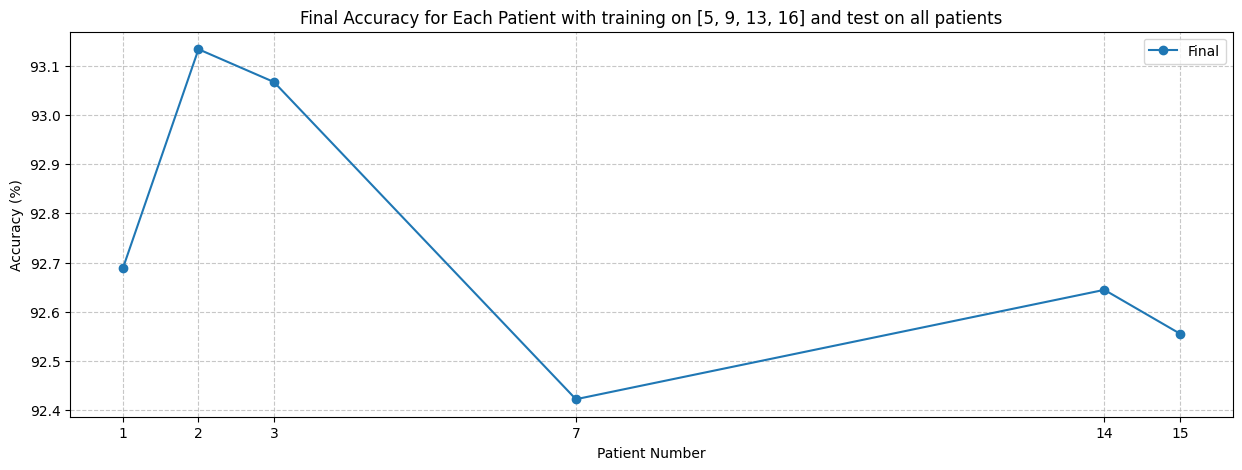

In [ ]:
final_accuracies=[]
threshold=0.5
for i in excluded_people:
    mse_final=temp_sc*mse_temp[i-1]+hr_sc*mse_hr[i-1]+spo2_sc*mse_spo2[i-1]+pr_sc*mse_pr[i-1]+ecg_sc*mse_ecg[i-1]
    # print(min(mse_final),max(mse_final))
    mse_final=np.where(mse_final>threshold,1,0)
    # mse_final=np.ones(mse_final.shape)
    final_accuracies.append(accuracy_score(df_test['Anomaly'],mse_final)*100)

plt.figure(figsize=(15, 5))
plt.plot(excluded_people, final_accuracies, marker='o', linestyle='-', label="Final")
plt.xticks(excluded_people)  # Set x-axis ticks to patient numbers
plt.xlabel("Patient Number")
plt.ylabel("Accuracy (%)")
plt.title(f"Final Accuracy for Each Patient with training on {list_t} and test on all patients")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)  # Add a light grid for readability

plt.show()

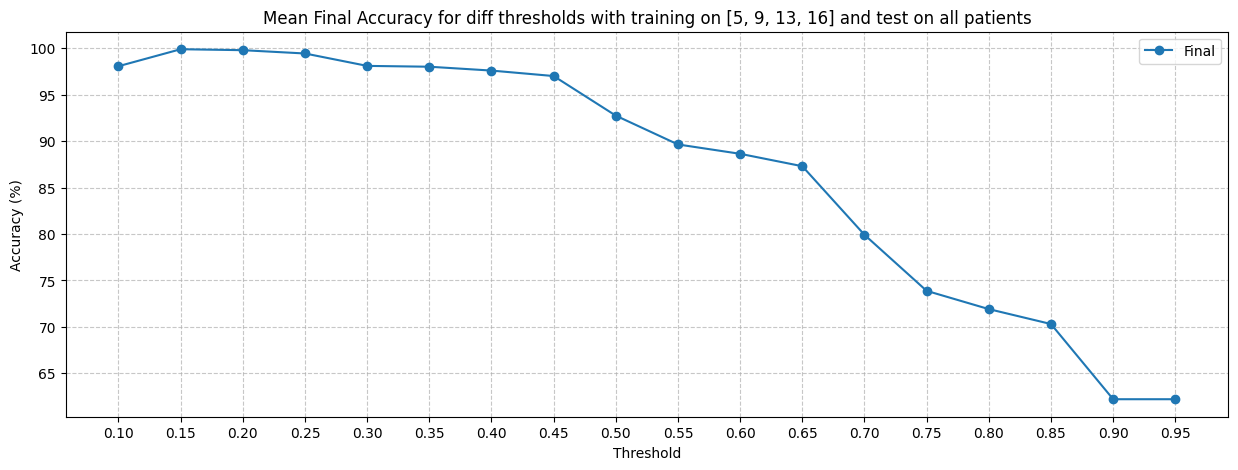

In [ ]:
final_accuracies_mean=[]
thresholds=np.arange(0.1,1,0.05)
for threshold in thresholds:
    final_accuracies=[]
    for i in excluded_people:
        mse_final=temp_sc*mse_temp[i-1]+hr_sc*mse_hr[i-1]+spo2_sc*mse_spo2[i-1]+pr_sc*mse_pr[i-1]+ecg_sc*mse_ecg[i-1]
        # print(min(mse_final),max(mse_final))
        mse_final=np.where(mse_final>threshold,1,0)
        # mse_final=np.ones(mse_final.shape)
        final_accuracies.append(accuracy_score(df_test['Anomaly'],mse_final)*100)
    final_accuracies_mean.append(np.mean(final_accuracies))

plt.figure(figsize=(15, 5))
plt.plot(thresholds, final_accuracies_mean, marker='o', linestyle='-', label="Final")
plt.xticks(thresholds)  # Set x-axis ticks to patient numbers
plt.xlabel("Threshold")
plt.ylabel("Accuracy (%)")
plt.title(f"Mean Final Accuracy for diff thresholds with training on {list_t} and test on all patients")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)  # Add a light grid for readability

plt.show()

0.345239310508006 4.842612563762286 4.926591079004041 0.7114261572898705 32.11723314660891


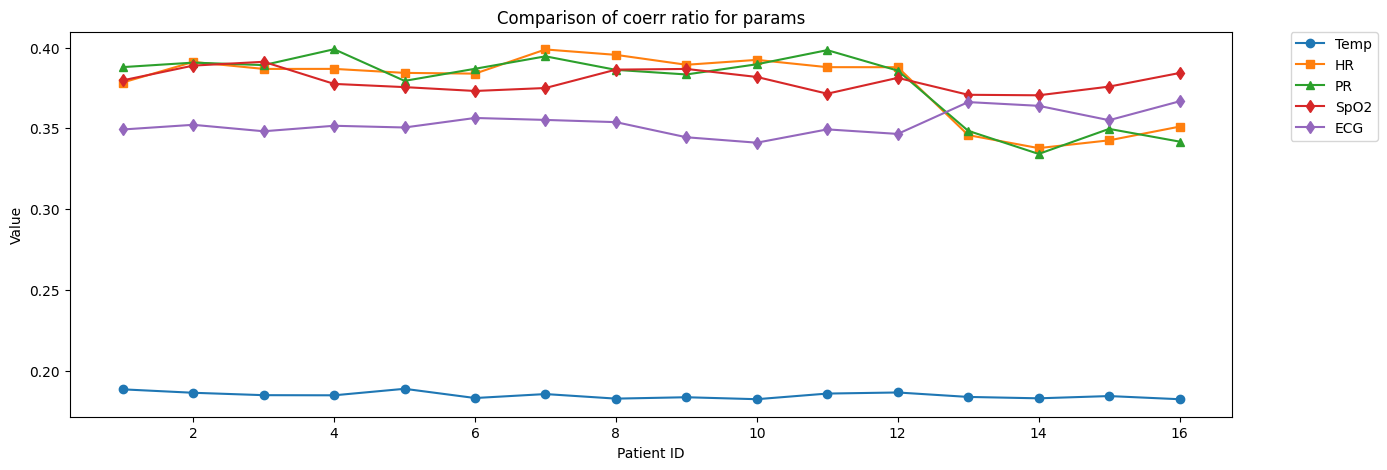

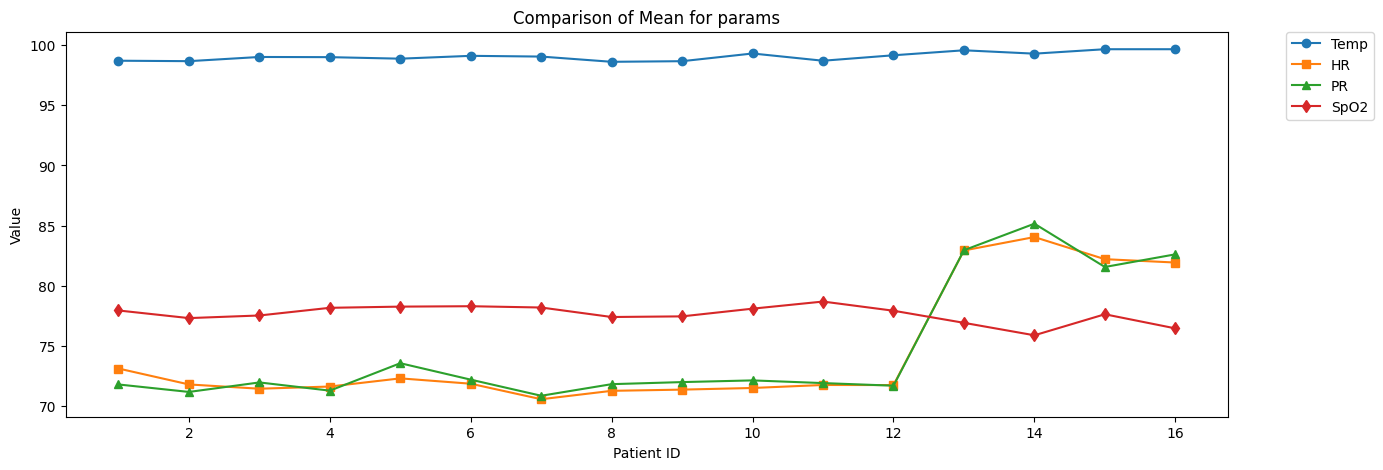

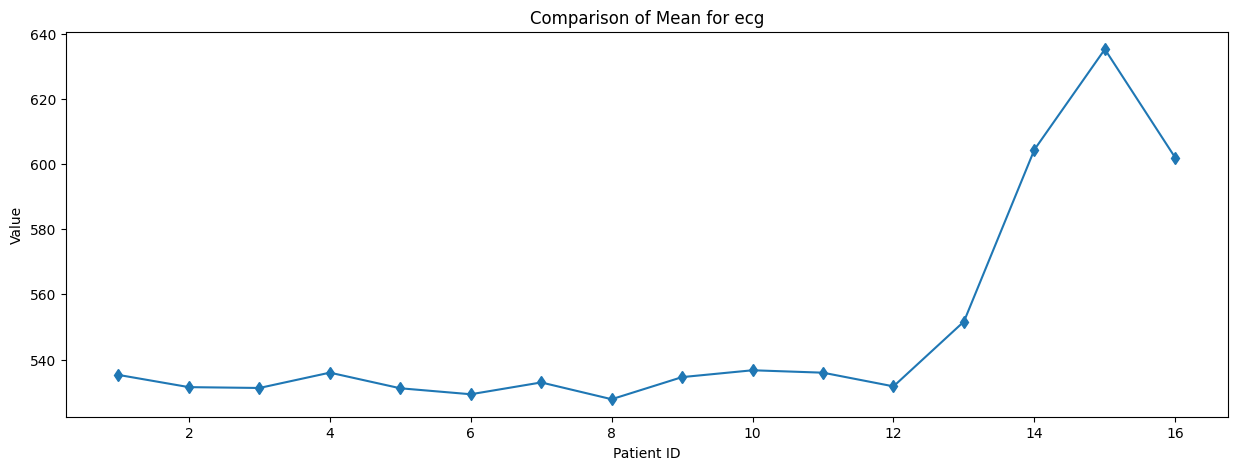

In [ ]:
# checking variability using coefficent of variance ( std/mean)
coeff_var_temp=[]
coeff_var_hr=[]
coeff_var_pr=[]
coeff_var_spo2=[]
coeff_var_ecg=[]
mean_temp=[]
mean_hr=[]
mean_pr=[]
mean_spo2=[]
mean_ecg=[]
for i in range(1,17):
    df=gen_data_w(i)
    # ['Body_Temperature', 'Heart_Rate', 'Pulse_Rate', 'SpO2', 'ECG', 'Anomaly_Type', 'Normal', 'Anomaly']
    temp=df['Body_Temperature']
    hr=df['Heart_Rate']
    pr=df['Pulse_Rate']
    spo2=df['SpO2']
    ecg=df['ECG']
    
    coeff_var_temp.append(np.std(temp)/np.mean(temp))
    coeff_var_hr.append(np.std(hr)/np.mean(hr))
    coeff_var_pr.append(np.std(pr)/np.mean(pr))
    coeff_var_spo2.append(np.std(spo2)/np.mean(spo2))
    coeff_var_ecg.append(np.std(ecg)/np.mean(ecg))
    mean_temp.append(np.mean(temp))
    mean_hr.append(np.mean(hr))
    mean_pr.append(np.mean(pr))
    mean_spo2.append(np.mean(spo2))
    mean_ecg.append(np.mean(ecg))

#plotting
plt.figure(figsize=(15,5))
plt.plot(np.arange(1,17),coeff_var_temp,marker='o',linestyle='-',label="Temp")
plt.plot(np.arange(1,17),coeff_var_hr,marker='s',linestyle='-',label="HR")
plt.plot(np.arange(1,17),coeff_var_pr,marker='^',linestyle='-',label="PR")
plt.plot(np.arange(1,17),coeff_var_spo2,marker='d',linestyle='-',label="SpO2")
plt.plot(np.arange(1,17),coeff_var_ecg,marker='d',linestyle='-',label="ECG")
plt.xlabel("Patient ID")
plt.ylabel("Value")
plt.title("Comparison of coerr ratio for params")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.figure(figsize=(15,5))
plt.plot(np.arange(1,17),mean_temp,marker='o',linestyle='-',label="Temp")
plt.plot(np.arange(1,17),mean_hr,marker='s',linestyle='-',label="HR")
plt.plot(np.arange(1,17),mean_pr,marker='^',linestyle='-',label="PR")
plt.plot(np.arange(1,17),mean_spo2,marker='d',linestyle='-',label="SpO2")
# plt.plot(np.arange(1,17),mean_ecg,marker='d',linestyle='-',label="ECG")
plt.xlabel("Patient ID")
plt.ylabel("Value")
plt.title("Comparison of Mean for params")
plt.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0.)

plt.figure(figsize=(15,5))
plt.plot(np.arange(1,17),mean_ecg,marker='d',linestyle='-',label="ECG")
plt.xlabel("Patient ID")
plt.ylabel("Value")
plt.title("Comparison of Mean for ecg")
print(np.std(mean_temp),np.std(mean_hr),np.std(mean_pr),np.std(mean_spo2),np.std(mean_ecg))

In [ ]:
K = 5  # Number of features
rmse = np.sqrt((mse_train_ecg + mse_train_spo2 + mse_train_pr + mse_train_hr + mse_train_temp) / K)

In [ ]:
Q1 = np.quantile(rmse, 0.25)
Q2 = np.quantile(rmse, 0.5)
Q3 = np.quantile(rmse, 0.75)
IQR = Q3 - Q1
Min = Q1- 3*IQR
Max = Q3 + 3*IQR

In [ ]:
#Training window
TRW = []
for i in range(len(rmse)):
    if rmse[i] > Min and rmse[i] < Q1:
        state = 0
    elif rmse[i] > Q1 and rmse[i] < Q2:
        state = 1
    elif rmse[i] > Q2 and rmse[i] < Q3:
        state = 2
    elif rmse[i] > Q3 and rmse[i] < Max:
        state = 3
    TRW.append(state)


In [ ]:
q0 = TRW.count(0)/len(TRW)
q1 = TRW.count(1)/len(TRW)
q2 = TRW.count(2)/len(TRW)
q3 = TRW.count(3)/len(TRW)

Q = [q0, q1, q2, q3]

print(Q)

[0.2504320987654321, 0.25037037037037035, 0.25049382716049384, 0.2487037037037037]


In [ ]:
states = np.unique(TRW)
num_states = len(states)

N = np.zeros((num_states, num_states), dtype=int)

for i in range(len(TRW) - 1):
    current_state = TRW[i]
    next_state = TRW[i + 1]
    N[current_state, next_state] += 1

T = np.sum(N, axis=1, keepdims=True)  

P = np.divide(N, T, where=(T != 0))  # Avoid division by zero

print("Transition Count Matrix (N):\n", N)
print("Outgoing Transitions (T):\n", T.flatten())
print("Transition Probability Matrix (P):\n", P)


Transition Count Matrix (N):
 [[4147 3928 4058 4095]
 [4036 4119 4087 3981]
 [4085 4118 4050 3979]
 [3960 4059 4037 4060]]
Outgoing Transitions (T):
 [16228 16223 16232 16116]
Transition Probability Matrix (P):
 [[0.25554597 0.24205078 0.25006162 0.25234163]
 [0.24878259 0.25389879 0.25192628 0.24539234]
 [0.25166338 0.2536964  0.24950715 0.24513307]
 [0.24571854 0.2518615  0.2504964  0.25192355]]


In [ ]:
rmse_test = np.sqrt((mse_test_ecg + mse_test_spo2 + mse_test_pr + mse_test_hr + mse_test_temp) / K)

In [ ]:
Q1_test = np.quantile(rmse_test, 0.25)
Q2_test = np.quantile(rmse_test, 0.5)
Q3_test = np.quantile(rmse_test, 0.75)
IQR_test = Q3_test - Q1_test
Min_test = Q1_test- 3*IQR_test
Max_test = Q3_test + 3*IQR_test

In [ ]:
#Testing window
TW = []
for i in range(len(rmse_test)):
    if rmse_test[i] > Min_test and rmse_test[i] < Q1_test:
        state = 0
    elif rmse_test[i] > Q1_test and rmse_test[i] < Q2_test:
        state = 1
    elif rmse_test[i] > Q2_test and rmse_test[i] < Q3_test:
        state = 2
    elif rmse_test[i] > Q3_test and rmse_test[i] < Max_test:
        state = 3
    TW.append(state)


In [ ]:
window_size = 5
joint_probabilities = []
left = 0
right = window_size
n = len(TW)-1

while right<n :
    window = TW[left:right]
    joint_prob = Q[window[0]]
    for i in range(1, window_size):
        prev_state = window[i-1]
        curr_state = window[i]
        joint_prob *= P[prev_state, curr_state]
    left +=1
    right+=1
    joint_probabilities.append(joint_prob)
    print(f"Window {right + 1}: {window} -> P(SW_{right}) = {joint_prob:.6f}")

Window 7: [2, 3, 3, 2, 3] -> P(SW_6) = 0.000948
Window 8: [3, 3, 2, 3, 2] -> P(SW_7) = 0.000969
Window 9: [3, 2, 3, 2, 3] -> P(SW_8) = 0.000943
Window 10: [2, 3, 2, 3, 2] -> P(SW_9) = 0.000943
Window 11: [3, 2, 3, 2, 2] -> P(SW_10) = 0.000959
Window 12: [2, 3, 2, 2, 3] -> P(SW_11) = 0.000939
Window 13: [3, 2, 2, 3, 3] -> P(SW_12) = 0.000965
Window 14: [2, 2, 3, 3, 3] -> P(SW_13) = 0.000970
Window 15: [2, 3, 3, 3, 2] -> P(SW_14) = 0.000974
Window 16: [3, 3, 3, 2, 2] -> P(SW_15) = 0.000992
Window 17: [3, 3, 2, 2, 3] -> P(SW_16) = 0.000965
Window 18: [3, 2, 2, 3, 2] -> P(SW_17) = 0.000959
Window 19: [2, 2, 3, 2, 2] -> P(SW_18) = 0.000956
Window 20: [2, 3, 2, 2, 2] -> P(SW_19) = 0.000956
Window 21: [3, 2, 2, 2, 2] -> P(SW_20) = 0.000973
Window 22: [2, 2, 2, 2, 2] -> P(SW_21) = 0.000969
Window 23: [2, 2, 2, 2, 3] -> P(SW_22) = 0.000952
Window 24: [2, 2, 2, 3, 3] -> P(SW_23) = 0.000961
Window 25: [2, 2, 3, 3, 3] -> P(SW_24) = 0.000970
Window 26: [2, 3, 3, 3, 3] -> P(SW_25) = 0.000980
Window 

In [ ]:
min(joint_probabilities)

0.000895387207810593

In [ ]:
max(joint_probabilities)

0.0010661447041820332

In [ ]:
threshold = 0.001 

count_below_threshold = sum(prob < threshold for prob in joint_probabilities)

print(f"Number of elements below {threshold}: {count_below_threshold}")

Number of elements below 0.001: 2306
